(activity6_live)=
 
# Activity 6: Holdout and model evaluation (Live)

**2026-02-12**

# Imports and previous models

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from typing import Self

In [20]:
def rmse(y_hat: np.ndarray, y: np.ndarray) -> float:
    """Root mean squared error."""
    assert y_hat.shape == y.shape

    # TODO: compute the RMSE, using the functions we practiced on WS 1
    return np.sqrt( np.mean( (y_hat - y)**2))

Below are implementations of the models we've built so far:

:::{tip}

If you click on arrow near the blue bar at the top of the heading, you can collapse the code which can help organize the notebook.

:::

In [21]:
class MeanRegressor(BaseEstimator):
    """Simple model that predicts the mean of the training data."""

    # constructors in Python are defined using the `__init__` method
    # A quirk of Python OOP: the first argument is always `self`, which refers to the object itself
    def __init__(self):
        pass


    # fit method trains the model on the given data, and always takes X and y as arguments
    def fit(self, X, y):
        """Fits the mean regressor to the training data.

        Args:
            X: the data examples of shape (n, p)
            y: the answers vector of shape (n,)

        Returns:
            self: the fitted model
        """
        # fitted model parameters are stored in `self` as instance variables and suffixed with `_`
        self.mean_ = np.mean(y)

        return self

    # predict method makes predictions on new data, and always takes X as an argument
    def predict(self, X):
        """Predicts the values for new points X.

        This model will only predict the mean value of the fitted data for all new points.

        Args:
            X: the new points of shape (n_new, p)

        Returns:
            the predicted values of shape (n_new,)
        """
        
        predictions = []

        
        for x in X:
            predictions.append(self.mean_) 

        return np.array(predictions)


In [22]:
def find_k_nearest_indices(x: np.ndarray, X_train: np.ndarray, k: int) -> list:
    """Finds the indices of the k nearest neighbors to a new point x.
    
    Args:
        x: the new point of shape (m,)
        X_train: the training data of shape (n, m)
        k: the number of nearest neighbors to find

    Returns:
        the indices of the k nearest neighbors to x in X_train
    """
    dists = np.sqrt(np.sum((X_train - x)**2, axis=1))
    sorted_indices = np.argsort(dists)
    return sorted_indices[:k]


# Our KNNRegressor class extends the BaseEstimator class
class KNNRegressor(BaseEstimator):
    """KNN regressor model."""
    

    def __init__(self, n_neighbors: int):
        """Initializes the KNN regressor model.
        
        Args:
            n_neighbors: the number of neighbors to use for the KNN regressor
        """

        # self.var_name is an instance variable that can be accessed by any method in the class
        self.n_neighbors = n_neighbors


    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """Fits the KNN regressor to the training data.

        Note that KNN models do not have any functions or features that need to be fit, 
        so all this method does is store the training data as instance variables.

        Args:
            X: the feature matrix of shape (n, m)
            y: the target vector of shape (n,)

        Returns:
            self: the fitted model
        """

        # Use self to store the training data in the instance variables
        self.X_ = X
        self.y_ = y

        return self


    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predicts the values of a set of new points X.

        Args:
            X: the new points of shape (n_new, m)

        Returns:
            the predicted values of shape (n_new,)
        """

        assert self.X_.shape[1] == X.shape[1], "X must have the same number of features as the training data"

        predictions = []

        # this loops over the rows of X
        for x in X:
            # Find the k nearest neighbors to x
            k_nearest_indices = find_k_nearest_indices(x, self.X_, self.n_neighbors)

            # Compute the average of the k nearest neighbors, append to predictions
            predictions.append(np.mean(self.y_[k_nearest_indices]))

        return np.array(predictions)

In [23]:
# NOTE: this is called "simple" as a statistical term for one feature, not because it's simple to implement
class SimpleLinearRegression(BaseEstimator):

    def __init__(self):
        # There are no (hyper)parameters to set
        pass


    def fit(self, X: np.ndarray, y: np.ndarray) -> Self:
        """Fit the model to training data.

        Args:
            X: a 2D numpy array of shape (n, 1)
            y: a 1D numpy array of shape (n,)

        Returns:
            self: the fitted model
        """
        

        n = X.shape[0]
        x = X.flatten()
        # NOTE: we need to be super careful about the shape of the arrays!
        self.w1_ = (n * np.sum(x * y) - np.sum(x) * np.sum(y)) / (n * np.sum(x**2) - (np.sum(x) ** 2))
        self.w0_ = np.mean(y) - self.w1_ * np.mean(x)

        return self


    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict on new data.

        Args:
            X: a 2D numpy array of shape (n_new, 1)

        Returns:
            y_hat: a 1D numpy array of shape (n_new,)
        """
        return self.w0_ + self.w1_ * X.flatten()
        

# Part 1: train/test holdout split

In [24]:
# Load in data
housing_df = pd.read_csv("~/COMSC-335/data/housing_data.csv")

In [25]:
# TODO examine the first few rows and last few rows of the data
housing_df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
4995,4.1064,16.0,5.023155,1.024602,1769.0,2.560058,33.86,-117.78,2.461
4996,5.6454,33.0,5.642298,1.000000,1235.0,3.224543,33.90,-117.99,2.028
4997,4.7750,24.0,5.560458,1.071895,2829.0,4.622549,37.29,-121.84,1.919
4998,2.9551,41.0,4.118541,1.060790,655.0,1.990881,33.90,-118.36,2.050
4999,6.0471,17.0,6.535849,0.979245,1713.0,3.232075,33.61,-117.66,2.484


In [26]:
# TODO get the column names
housing_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

In [27]:
# TODO get the number of rows and columns
housing_df.shape

(5000, 9)

The features we have are:

- `MedInc`:        median income in block group
- `HouseAge`:      median house age in block group
- `AveRooms`:      average number of rooms per household
- `AveBedrms`:     average number of bedrooms per household
- `Population`:    block group population
- `AveOccup`:      average number of household members
- `Latitude`:      block group latitude
- `Longitude`:     block group longitude

The answer we want to predict is:
- `MedHouseVal`: median house value in $100,000s


Single columns in pandas can be accessed with the column name:

In [28]:
housing_df["HouseAge"]

0       48.0
1       36.0
2       31.0
3       38.0
4       52.0
        ... 
4995    16.0
4996    33.0
4997    24.0
4998    41.0
4999    17.0
Name: HouseAge, Length: 5000, dtype: float64

Multiple columns can be accessed with a list of column names:

In [29]:
housing_df[["AveRooms", "HouseAge", "Longitude"]]

,AveRooms,HouseAge,Longitude
0,3.807074,48.0,-118.32
1,5.860390,36.0,-118.01
2,5.345550,31.0,-118.23
3,4.990074,38.0,-117.31
4,4.806283,52.0,-118.21
...,...,...,...
4995,5.023155,16.0,-117.78
4996,5.642298,33.0,-117.99
4997,5.560458,24.0,-121.84
4998,4.118541,41.0,-118.36


There are many ways to select rows from a pandas DataFrame. Similar to numpy, we can use square brackets and slicing:

In [30]:
# select the first 1000 rows
housing_df[0:1000]

# select the last 1000 rows, uncommon
housing_df[-1000:]

# select the rows starting at index 1000
print(housing_df[1000:].shape)

(4000, 9)


Let's split the data into training and test sets. We'll use the **first** 80% of the data for training and the **last 20%** for testing. Complete the code below to create the `X_train`, `X_test`, `y_train`, and `y_test` variables.

In [31]:
# TODO split the data into training and test sets
housing_train = housing_df[:4000]
housing_test = housing_df[-1000:]

# TODO what are some assertions we can do to test our splits?
assert housing_train.shape == (4000, 9)
assert housing_test.shape == (1000, 9)

Columns can also be removed with the [drop()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html) method:

In [32]:
# remove the y column
X_train = housing_train.drop(columns=["MedHouseVal"])
X_test = housing_test.drop(columns=["MedHouseVal"])

# save the y column
y_train = housing_train["MedHouseVal"]
y_test = housing_test["MedHouseVal"]

# Part 2: Feature exploration

Seaborn is a high-level plotting library that has strong integration with pandas DataFrames. For a given plot, we often specify the following parameters:

- `x`: the column name of the x-axis
- `y`: the column name of the y-axis
- `data`: the pandas DataFrame to plot

:::{warning}

Remember that we should only be looking at the training data when exploring the relationships between features and the target!

:::

We'll visualize the data using [sns.scatterplots](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) below:

<Axes: xlabel='HouseAge', ylabel='MedHouseVal'>

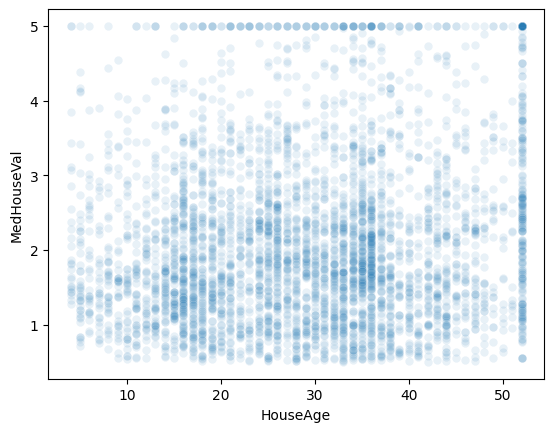

In [33]:
# plots HouseAge vs MedHouseVal
# alpha controls the transparency of the points
sns.scatterplot(x="HouseAge", y="MedHouseVal", data=housing_train, alpha=0.1)

The features we have are:

- `MedInc`:        median income in block group
- `HouseAge`:      median house age in block group
- `AveRooms`:      average number of rooms per household
- `AveBedrms`:     average number of bedrooms per household
- `Population`:    block group population
- `AveOccup`:      average number of household members
- `Latitude`:      block group latitude
- `Longitude`:     block group longitude

The answer we want to predict is:

- `MedHouseVal`: median house value in $100,000s

In groups of 2-3 around you, split up the features to plot on the x-axis, always keeping the y-axis as `MedHouseVal`. Compare plots to discuss what the "best" 2-3 features for predicting `MedHouseVal` are, and vote for them in the PollEverywhere:

https://pollev.com/tliu

<Axes: xlabel='Latitude', ylabel='MedHouseVal'>

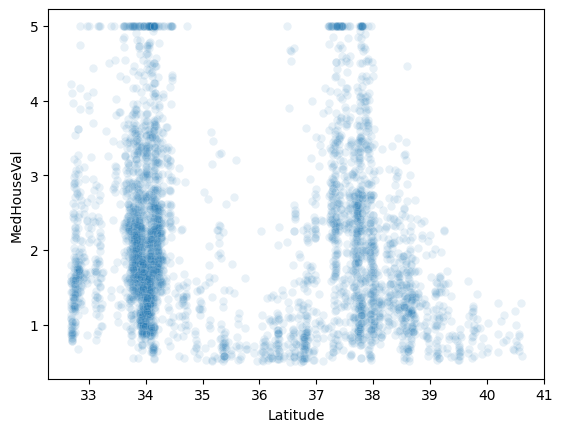

In [34]:
# TODO your scatterplots here
sns.scatterplot(x="Latitude", y="MedHouseVal", data=housing_train, alpha=0.1)

# Part 3: Model evaluation and benchmarking

Let's now fit a `MeanRegressor` model as a baseline for us to benchmark our other models against:

In [35]:
# TODO update this to change the features we're using
feats_to_include = ["HouseAge"]

# initialize the model
regressor = MeanRegressor()

# fit the model on the training data
regressor.fit(X_train[feats_to_include].to_numpy(), y_train.to_numpy())

# make predictions on both the training and test sets
y_hat_train = regressor.predict(X_train[feats_to_include].to_numpy())
y_hat_test = regressor.predict(X_test[feats_to_include].to_numpy())

# compute the RMSE
rmse_train = rmse(y_hat_train, y_train)
rmse_test = rmse(y_hat_test, y_test)

# Rounds the RMSE to 2 decimal places
print(f"MeanRegressor RMSE on training set: {rmse_train:.2f}")
print(f"MeanRegressor RMSE on test set: {rmse_test:.2f}")

MeanRegressor RMSE on training set: 1.11
MeanRegressor RMSE on test set: 1.07


Now, let's go model-hunting: find a model that beats the MeanRegressor RMSE (lower is better) on the test set. Copy the cell above and modify it to try new model and feature combinations:

- `KNNRegressor`: try different values of `n_neighbors`
- `SimpleLinearRegression`: try different features, but note that this model only takes in 1 feature
- `LinearRegression`: try different feature combinations

Again, you can discuss with folks around you on a strategy to search through models. 

As you try new models and features, discuss with folks around you any discrepancies you see between the training and test set RMSEs. Is one number usually higher than the other?

After trying out a few models with your group, submit your best test set RMSE rounded to 2 decimal places to the PollEverywhere:

https://pollev.com/tliu

In [ ]:
# TODO update this to change the features we're using
feats_to_include = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"]

# initialize the model
regressor = LinearRegression()

# fit the model on the training data
regressor.fit(X_train[feats_to_include].to_numpy(), y_train.to_numpy())

# make predictions on both the training and test sets
y_hat_train = regressor.predict(X_train[feats_to_include].to_numpy())
y_hat_test = regressor.predict(X_test[feats_to_include].to_numpy())

# compute the RMSE
rmse_train = rmse(y_hat_train, y_train)
rmse_test = rmse(y_hat_test, y_test)

# Rounds the RMSE to 2 decimal places
print(f"LinearRegression with all 8 features RMSE on training set: {rmse_train:.2f}")
print(f"LinearRegression with all 8 features RMSE on test set: {rmse_test:.2f}")

LinearRegression with all features RMSE on training set: 0.62
LinearRegression with all features RMSE on test set: 0.63


In [42]:
# TODO update this to change the features we're using
feats_to_include = ["MedInc",]

# initialize the model
regressor = KNNRegressor(n_neighbors=1)

# fit the model on the training data
regressor.fit(X_train[feats_to_include].to_numpy(), y_train.to_numpy())

# make predictions on both the training and test sets
y_hat_train = regressor.predict(X_train[feats_to_include].to_numpy())
y_hat_test = regressor.predict(X_test[feats_to_include].to_numpy())

# compute the RMSE
rmse_train = rmse(y_hat_train, y_train)
rmse_test = rmse(y_hat_test, y_test)

# Rounds the RMSE to 2 decimal places
print(f"KNNRegressor with 1 neighbor RMSE on training set: {rmse_train:.2f}")
print(f"KNNRegressor with 1 neighbor RMSE on test set: {rmse_test:.2f}")

KNNRegressor with 1 neighbor RMSE on training set: 0.45
KNNRegressor with 1 neighbor RMSE on test set: 1.12


In [48]:
# TODO update this to change the features we're using
feats_to_include = ["MedInc",]

# initialize the model
regressor = KNNRegressor(n_neighbors=20)

# fit the model on the training data
regressor.fit(X_train[feats_to_include].to_numpy(), y_train.to_numpy())

# make predictions on both the training and test sets
y_hat_train = regressor.predict(X_train[feats_to_include].to_numpy())
y_hat_test = regressor.predict(X_test[feats_to_include].to_numpy())

# compute the RMSE
rmse_train = rmse(y_hat_train, y_train)
rmse_test = rmse(y_hat_test, y_test)

# Rounds the RMSE to 2 decimal places
print(f"KNNRegressor with 20 neighbors RMSE on training set: {rmse_train:.2f}")
print(f"KNNRegressor with 20 neighbors RMSE on test set: {rmse_test:.2f}")

KNNRegressor with 20 neighbors RMSE on training set: 0.79
KNNRegressor with 20 neighbors RMSE on test set: 0.81
